# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate
from scipy.interpolate import griddata

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/bias1_lag10/bias2/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
new_deep: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
deep: PYTORCH_MODEL FILE=../../deeptica_lag10/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
# bias 
opes: OPES_METAD ARG=new_deep.node-0,deep.node-0 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

#funziona solo se usi entrambe le cv
#static: OPES_METAD ARG=deep.node-0 PACE=100000000 BARRIER=40 FILE=KERNELS STATE_RFILE=../bck.0.RestartKernels RESTART=YES

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

Text(0, 0.5, '$\\psi$')

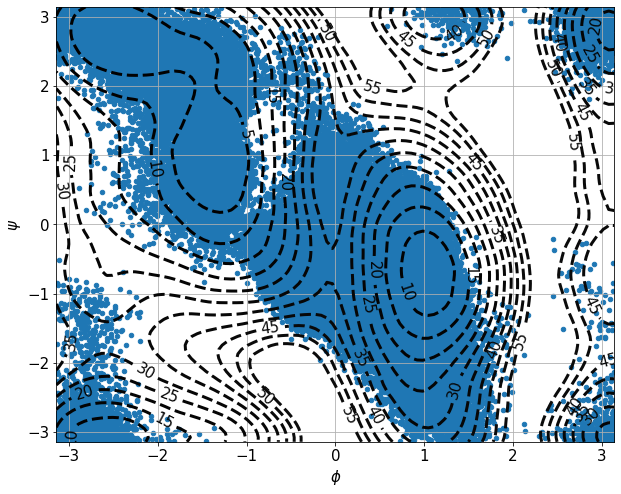

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

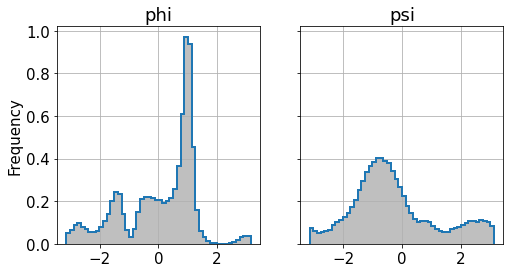

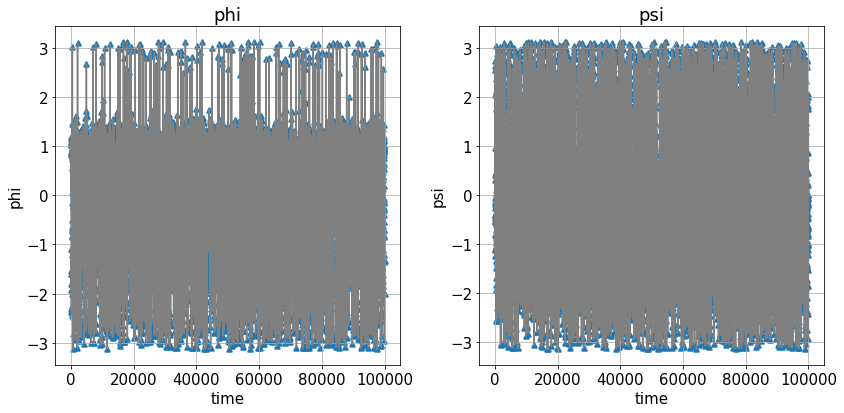

In [5]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

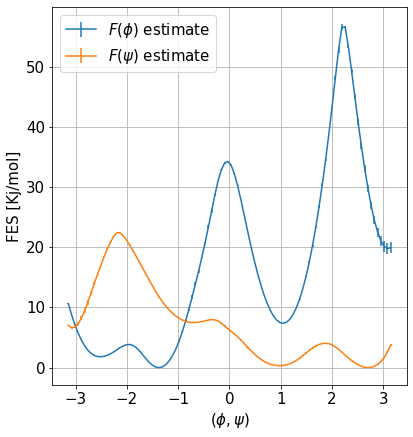

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

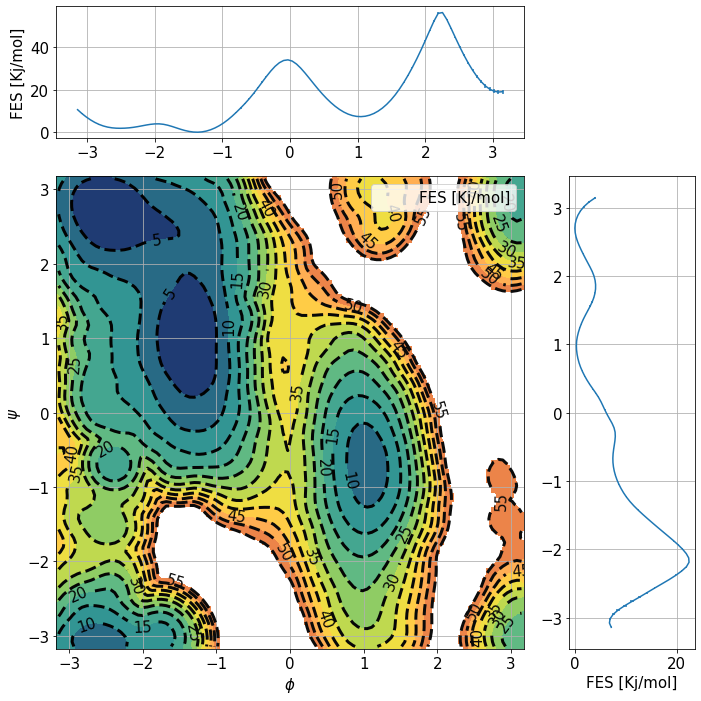

In [7]:
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)
fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 4)#, figure=fig)

ax_scatter = fig.add_subplot(gs[1:4,0:3])
ax_hist_x = fig.add_subplot(gs[0,:3])
ax_hist_y = fig.add_subplot(gs[1:,3])

#-- 2D plot --#
fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
bounds = np.arange(0, 60, 5.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
)
c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
#fig.colorbar(c, ax=ax_scatter,label="FES [KbT]")
c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
ax_scatter.legend(["FES [Kj/mol]"])
c.clabel()
ax_scatter.grid()
ax_scatter.set_xlabel(r"$\phi$")
ax_scatter.set_ylabel(r"$\psi$")
#np.savetxt(folder+"fes.txt",fes,delimiter=" ")
#np.savetxt(folder+"grid0.txt",grid[0],delimiter=" ")
#np.savetxt(folder+"grid1.txt",grid[1],delimiter=" ")

#-- 1D plot --#
fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
ax_hist_x.errorbar(grid,fes,yerr=error)
ax_hist_x.set_ylabel("FES [Kj/mol]")
ax_hist_x.grid()
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)
ax_hist_y.errorbar(fes,grid,xerr=error)
ax_hist_y.set_xlabel("FES [Kj/mol]")
ax_hist_y.grid()

plt.tight_layout()
plt.show()

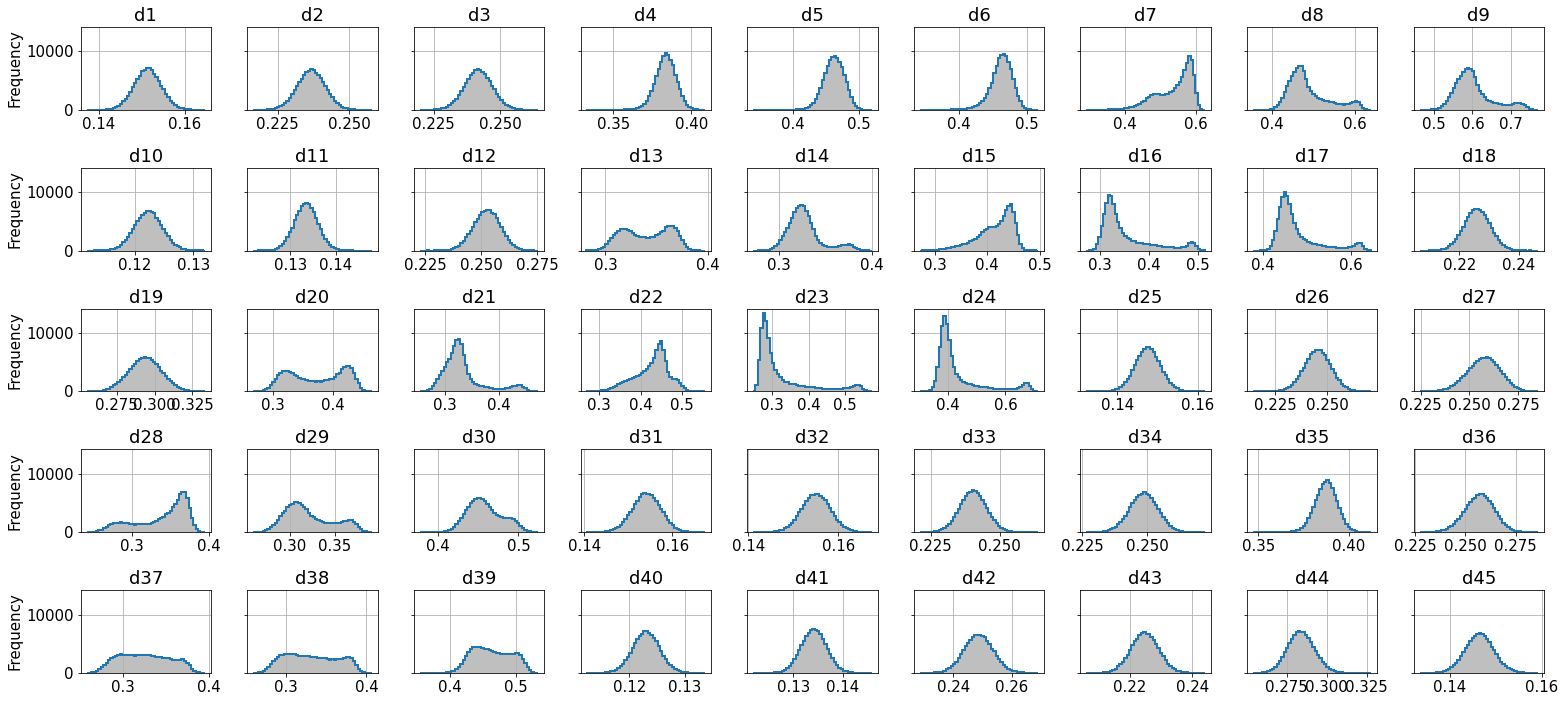

In [8]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [9]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':5,#10 ok
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [10]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Time-lagged pairs:	 199469
Training data:		 139628
Validation data:	 59841
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.625      -0.620      0.613  0.012  
100   -0.638      -0.626      0.620  0.017  
150   -0.653      -0.630      0.626  0.026  
200   -0.659      -0.645      0.629  0.028  
250   -0.685      -0.650      0.634  0.046  
INFO: Early stopping
285   -0.670      -0.648      0.633  0.030  
model saved
timescales:  [10.936195   1.4293975]
eigenvalues:  [0.6330554  0.03025853]
gap:  0.60279685


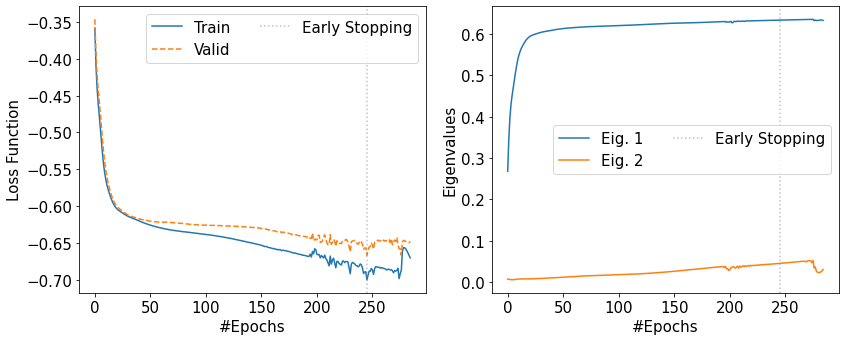

In [11]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [12]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

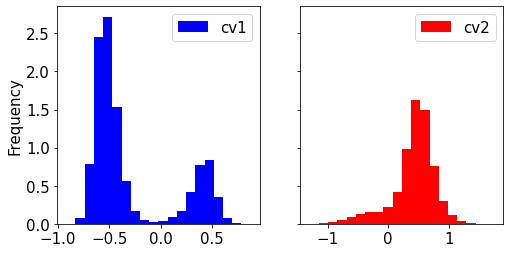

In [13]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

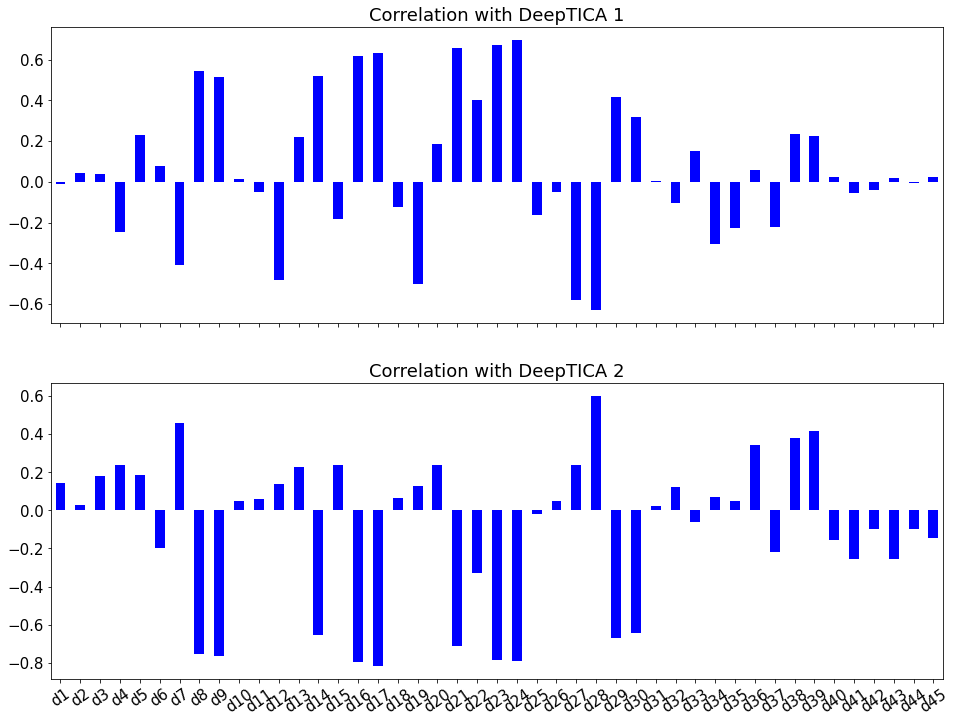

In [14]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from new cvs   

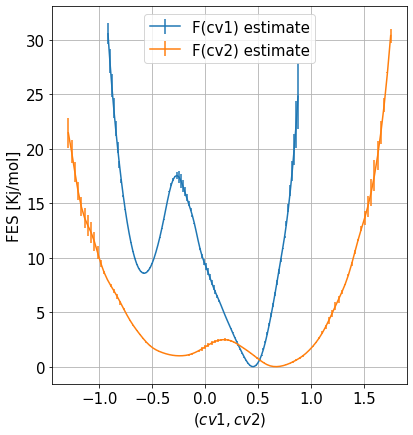

In [15]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### FES estimate from old cvs  

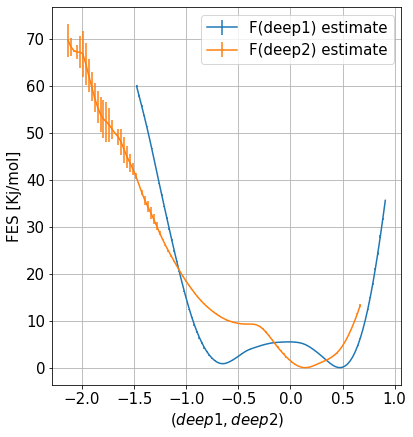

In [16]:
s = data.filter(regex="^deep.node-").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(deep1) estimate","F(deep2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(deep1,deep2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

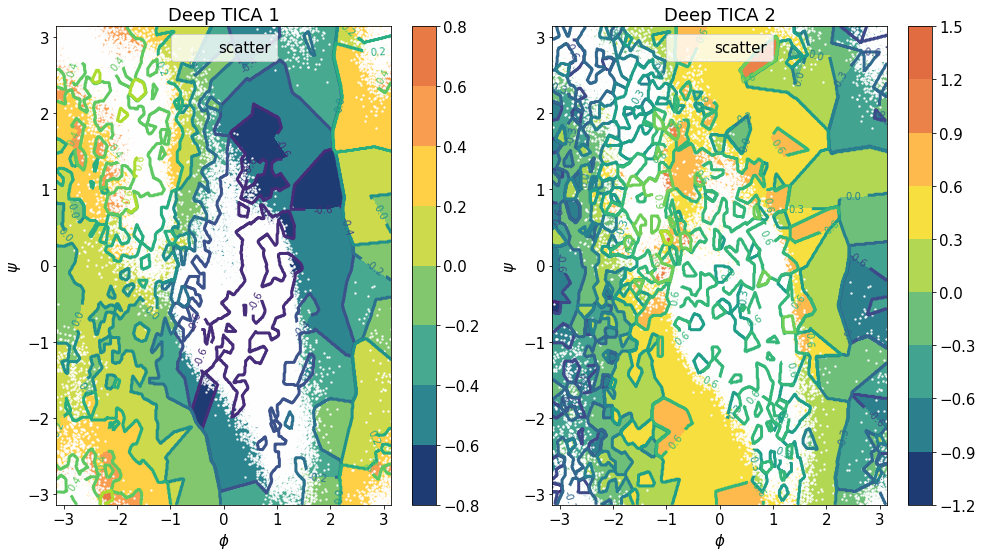

In [17]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
#lim = ((-np.pi,-1),(-0.5,np.pi))
#plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

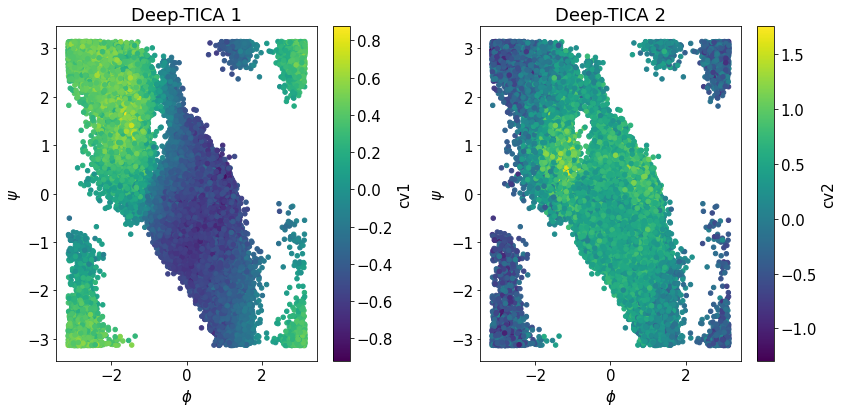

In [18]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [19]:
def Boltzmann_product(model0,model1,X,j=0,k=1,logweight=None,normed=False):

    if logweight is not None:
            weights= np.exp(logweight)
    else:
        weights=np.ones(X.shape[0])

    a = np.transpose(model0(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model1(torch.Tensor(X)).detach().cpu().numpy())[k]
    sumtot = np.multiply(np.multiply(a,weights),b).mean()

    if normed:
        sumcv1 = np.multiply(np.multiply(a,weights),a).mean()
        sumcv2 = np.multiply(np.multiply(b,weights),b).mean()
        return sumtot/np.sqrt(sumcv1*sumcv2)
    else:
        return sumtot

In [20]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

0.0037973558619643663

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [21]:
def orthogonal_cv(model,X,logweight=None,j=0,k=1):

    a = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[k]

    prod_ab = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=k)
    prod_aa = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=j) 

    c = b - prod_ab/(prod_aa) * a

    return c

#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X,logweight=logweight)
prod = np.multiply(np.multiply(cv1,np.exp(logweight)),new_cv2).mean()
print(prod)

7.430977535643678e-11


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

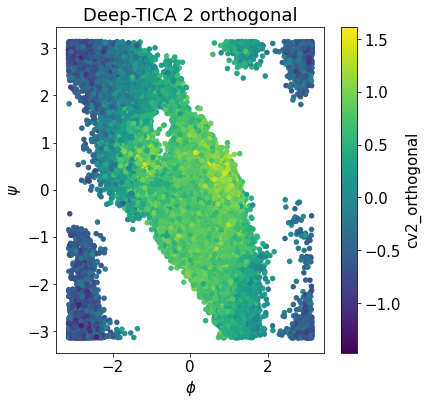

In [22]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="psi",x="phi",c="cv2_orthogonal",cmap="viridis",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title('Deep-TICA 2 orthogonal')

## $\Delta F$ Estimate

Text(0, 0.5, '$\\Delta F$ [Kj/mol]')

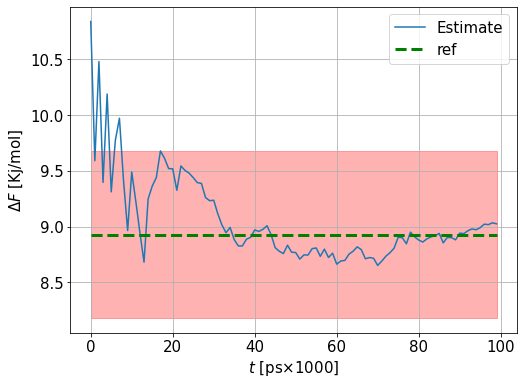

In [25]:
res = 8.92808817900219
#-- each step is 1ps --#
last = 1*1000*100 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))*sim_parameters["beta"]
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=1000

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) 
    ind2 = (grid>0) 
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)
    
    deltaf = np.append(deltaf,(1/sim_parameters["beta"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.3*kb*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [Kj/mol]")